In [5]:
#Preprocessing
import pandas as pd
df = pd.read_csv('/home/lakhwinder/parsed_ctr_500000.csv')
# Converting Date and time
df['hour'] = pd.to_datetime(df.hour).dt.hour
# Removing Unwanted Features
colomns_to_drop = ['id','site_id','site_domain','app_id','app_domain','device_id','device_ip','device_model','C1','C14','C15','C16','C17','C18','C19','C20','C21']
#Drop the coloumns
df = df.drop(colomns_to_drop,axis=1)
df.to_csv(r'/home/lakhwinder/preprocessed_500000.csv')

In [1]:
#  Model training using Logistic regression
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ctr-prediction').getOrCreate()
spark_df = spark.read.csv('hdfs://lakhwinder/preprocessed_500000.csv', header = True, inferSchema = True)
spark_df = spark_df.drop('_c0')
cols = spark_df.columns
#Handling Categorical Data
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
catergoricalFeature = ["banner_pos", "site_category", "app_category","device_type", "device_conn_type"]
stages = [] # stages in our Pipeline
for catergoricalFeat in catergoricalFeature:
    # StringIndexer for category Indexing
    strIndexer = StringIndexer(inputCol=catergoricalFeat, outputCol=catergoricalFeat + "Index").setHandleInvalid("skip")
    # Using OneHotEncoder
    ohencoder = OneHotEncoderEstimator(inputCols=[strIndexer.getOutputCol()], outputCols=[catergoricalFeat + "classVec"])
    # Add stages for pipeline
    stages += [strIndexer, ohencoder]

label_output = StringIndexer(inputCol="click", outputCol="label")
stages += [label_output]

numericCols = ["hour"]
assemblerInputs = [c + "classVec" for c in catergoricalFeature] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Applying Logistic regression
from pyspark.ml.classification import LogisticRegression
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(spark_df)
preppedDataDF = pipelineModel.transform(spark_df)

train, test = preppedDataDF.randomSplit([0.90, 0.10], seed = 2)
from time import *
start_time = time()
lrModel = LogisticRegression(featuresCol='features',labelCol = 'label', maxIter=10)
lrModel1 = lrModel.fit(train)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train the Model LR : %.3f seconds" % elapsed_time)

Time to train the Model LR : 18.186 seconds


In [3]:
trainingSummary = lrModel1.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for binary classification, using precision recall and f1-score with accuracy
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

objectiveHistory:
0.45430570251293145
0.44633430836316007
0.44487686086476236
0.4430134094105652
0.4426208971590958
0.44185707718214345
0.4410900402254555
0.44057593505710135
0.4404407673844047
0.4403957882836196
0.4403262498348738
False positive rate by label:
label 0: 0.9982370276812967
label 1: 0.0003210882751940577
True positive rate by label:
label 0: 0.9996789117248059
label 1: 0.0017629723187032945
Precision by label:
label 0: 0.8311971754215398
label 1: 0.5275590551181102
Recall by label:
label 0: 0.9996789117248059
label 1: 0.0017629723187032945
F-measure by label:
label 0: 0.907685990971949
label 1: 0.0035142010437701613
Accuracy: 0.8310256883467448
FPR: 0.8295838043032356
TPR: 0.831025688346745
F-measure: 0.7548760389136104
Precision: 0.7798806810080867
Recall: 0.831025688346745


In [4]:
predictions = lrModel1.transform(test)
#predictions.select('banner_pos','label','rawPrediction', 'probability', 'prediction').show(10)

In [5]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
accuracy_test = evaluator.evaluate(predictions)
print("Test Area Under ROC: %s" % (accuracy_test))

Test Area Under ROC: 0.6101698894369141


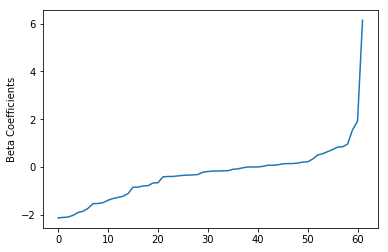

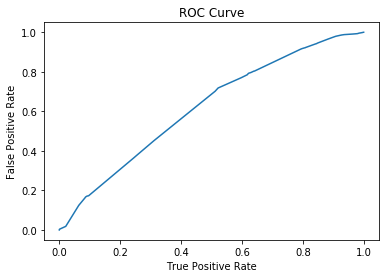

Training set areaUnderROC: 0.618990049282226


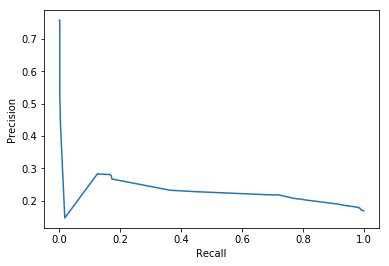

Precision is :0.7798806810080867
Recall is : 0.831025688346745


In [44]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
beta = np.sort(lrModel1.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

trainingSummary = lrModel1.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print('Precision is :' + str(precision))
print('Recall is : '+ str(recall))